# Загрузка библиотек

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, GlobalAveragePooling2D, Conv2D, Conv3D, MaxPooling3D, BatchNormalization, Dropout
from keras import utils as np_utils
from matplotlib import pyplot as plt
from random import  randint
from tqdm import tqdm
import os
import datetime
from keras.utils.vis_utils import plot_model
import json, codecs
from tensorflow_docs.vis import embed
import imageio
import dlib
from random import  randint
import cv2

# Datagenerator


In [ ]:
params = {'dim': (20,80,80),
          'batch_size': 64,
          'n_classes': 7,
          'n_channels': 1,
          'shuffle': True}

In [ ]:
class DataGenerator(keras.utils.all_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, part,list_IDs, batch_size, dim=(20,80,80), n_channels=1,
                 n_classes=7, shuffle=True):
        'Initialization'
        self.part = part
        self.dim = dim
        self.batch_size = batch_size

        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            try:
              X[i,] = np.load('vkr_npy/' + self.part + '/' +ID)
            # Store class
              y[i] = int(ID[0])
            except:
              print(ID)

        return X.reshape(X.shape[0],*self.dim, 1),keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)

# Создание наборов для обучения сети

In [ ]:
# Список файлов тренировочной выборки для подачи в датагенератор
path = 'vkr_npy/Train/'
# чтение записей
listID_train=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_train.append(entry.name)

path = 'vkr_npy/Val/'
# чтение записей
listID_val=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_val.append(entry.name)

path = 'vkr_npy/Test/'
# чтение записей
listID_test=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_test.append(entry.name)

In [ ]:
# Проверка на NAN роказала один массив, удалилла его из выборки /content/drive/MyDrive/npy_vkr/train/5_0.npy
for npy in tqdm(listID_train):
  X = np.load('vkr_npy/Train/' +npy)
  if np.any(np.isnan(X))==True:
    print(npy)

# Список файлов валидационной выборки для подачи в датагенератор
path = 'vkr_npy/Val/'
# чтение записей
listID_val=[]
with os.scandir(path) as listOfEntries:
    for entry in listOfEntries:
      listID_val.append(entry.name)



In [ ]:
training_generator = DataGenerator('Train',listID_train, 32)
validation_generator = DataGenerator('Val',listID_val,32)
test_generator = DataGenerator('test',listID_test,150 )

In [ ]:
# Посмотрим на структуру обучающих масиивов
lf = os.listdir('vkr_npy/Train/')
lf0 = [int(el[0])for el in lf ]
lf0 = pd.DataFrame(lf0)
print(lf0.groupby(by=lf0[0]).sum('1'))
print(lf0.groupby(by=lf0[0]).sum('1'))

# Функции

In [ ]:
# Для ппостроения графиков обучения
def plot_history(history): #Создание полотна для рисунка
    plt.figure(1, figsize=(18, 5))

    # Задание первой (левой) области для построения графиков
    plt.subplot(1, 2, 1)
    # Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
    plt.plot(history['loss'],
            label='Значение ошибки на обучающем наборе')
    plt.plot(history['val_loss'],
            label='Значение ошибки на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Значение ошибки')
    plt.legend()

    # Задание второй (правой) области для построения графиков
    plt.subplot(1, 2, 2)
    # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
    plt.plot(history['accuracy'],
            label='Доля верных ответов на обучающем наборе')
    plt.plot(history['val_accuracy'],
            label='Доля верных ответов на проверочном наборе')
    # Задание подписей осей
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Доля верных ответов')
    plt.legend()

    # Фиксация графиков и рисование всей картинки
    plt.show()


# Для сохранения истории обучения
class float32_encoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return obj.astype(np.float64)
        return json.JSONEncoder.default(self, obj)

def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4,cls=float32_encoder)

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

# Сверточные сети

## model от  MyCNNModel с весами классов

In [ ]:
class MyCNNModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.BN = tf.keras.layers.BatchNormalization()
    self.C3D1 = tf.keras.layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu')
    self.C3D2 = tf.keras.layers.Conv3D(32, (3, 3, 3), padding='same', activation='relu')
    self.fltn = tf.keras.layers.Flatten()
    self.dns1=tf.keras.layers.Dense(256, activation='relu')
    self.dns_out = tf.keras.layers.Dense(7, activation='softmax')
    self.MP = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))
    self.DOut = tf.keras.layers.Dropout(0.25)

  def call(self, inputs):
    x = self.BN(inputs)
    x = self.C3D1(x)
    x = self.C3D2(x)
    x = self.MP(x)
    x = self.DOut(x)
    x = self.fltn(x)
    x = self.dns1(x)
    x = self.DOut(x)
    return self.dns_out(x)

In [ ]:
model = MyCNNModel()
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-3), metrics=["accuracy"])

In [ ]:
history_ = model.fit(training_generator,
                    epochs=2,validation_data=validation_generator, class_weight = {0:1.,1:1.,2:0.9,3:0.8,4:0.7,5:0.9,6:0.9}, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/2
187/187 [==============================] - 50s 267ms/step - loss: 1.7204 - accuracy: 0.1352 - val_loss: 1.9440 - val_accuracy: 0.1756
Epoch 2/2
187/187 [==============================] - 50s 266ms/step - loss: 1.7051 - accuracy: 0.1517 - val_loss: 1.9337 - val_accuracy: 0.2098


In [ ]:
model.load_weights('vkr/CNN/CW_35-0.63.hdf5')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-8), metrics=["accuracy"])
history_ = model.fit(training_generator,
                    epochs=50,validation_data=validation_generator, class_weight = {0:1.,1:1.,2:0.9,3:0.8,4:0.7,5:0.9,6:0.9}, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
187/187 [==============================] - 50s 265ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 2.8114 - val_accuracy: 0.6302
Epoch 2/50
187/187 [==============================] - 49s 264ms/step - loss: 0.0076 - accuracy: 0.9963 - val_loss: 2.8069 - val_accuracy: 0.6295
Epoch 3/50
187/187 [==============================] - 49s 264ms/step - loss: 0.0072 - accuracy: 0.9968 - val_loss: 2.8282 - val_accuracy: 0.6287
Epoch 4/50
187/187 [==============================] - 49s 264ms/step - loss: 0.0072 - accuracy: 0.9973 - val_loss: 2.8229 - val_accuracy: 0.6287
Epoch 5/50
187/187 [==============================] - 49s 264ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 2.8092 - val_accuracy: 0.6302
Epoch 6/50
187/187 [==============================] - 50s 264ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 2.8355 - val_accuracy: 0.6272
Epoch 7/50
187/187 [==============================] - 50s 265ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 2.8149 - val_ac

Вывод: модель явно переобучается,уменьшение шага обучения не приводит к росту точности модели (63%). Вероятно, уменьшение числа нейронов в сверточных слоях может избавить модель от переобучения. Рассмотрим модель с двумя блоками сверток по 16 и 8 нейронов в каждом. Добавим коллбэк с расписанием уменьшения шага обучения по экспоненте.  

## model3 C3D-16-8 DS-256-7

In [ ]:
model3 = Sequential()
model3.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model3.add(Conv3D(16, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model3.add(Conv3D(16, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model3.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model3.add(Conv3D(8, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model3.add(Conv3D(8, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model3.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model3.add(Dropout(0.25)) # Слой регуляризации Dropout
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))# Полносвязный слой для классификации
model3.add(Dropout(0.25))# Слой регуляризации Dropout
model3.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # Компилируем сеть

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m3_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history_m3 = model3.fit(training_generator,
                    epochs=50,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
187/187 [==============================] - 66s 302ms/step - loss: 1.7560 - accuracy: 0.3130 - val_loss: 1.7326 - val_accuracy: 0.4204
Epoch 2/50
187/187 [==============================] - 56s 300ms/step - loss: 1.2715 - accuracy: 0.5398 - val_loss: 1.1934 - val_accuracy: 0.5670
Epoch 3/50
187/187 [==============================] - 56s 300ms/step - loss: 0.8769 - accuracy: 0.6887 - val_loss: 1.0480 - val_accuracy: 0.6287
Epoch 4/50
187/187 [==============================] - 56s 301ms/step - loss: 0.5923 - accuracy: 0.7906 - val_loss: 1.0389 - val_accuracy: 0.6592
Epoch 5/50
187/187 [==============================] - 56s 301ms/step - loss: 0.4405 - accuracy: 0.8521 - val_loss: 1.1044 - val_accuracy: 0.6570
Epoch 6/50
187/187 [==============================] - 56s 301ms/step - loss: 0.3221 - accuracy: 0.8937 - val_loss: 1.1441 - val_accuracy: 0.6763
Epoch 7/50
187/187 [==============================] - 56s 301ms/step - loss: 0.2635 - accuracy: 0.9179 - val_loss: 1.2980 - val_ac

In [ ]:
round(model.optimizer.lr.numpy(), 15)

1.83156e-10

Вывод: Точность увеличилась до 72%, продолжаем наращивать слои верток - четвертая модель содержит три блока по 16,8 и 4 нейрона.

## model4 C3D-16-8-4 DS-80-7 adam

In [ ]:
model4 = Sequential()
model4.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
model4.add(Dropout(0.25)) # Слой регуляризации Dropout
model4.add(Flatten())
model4.add(Dense(80, activation='relu'))# Полносвязный слой для классификации
model4.add(Dropout(0.25))# Слой регуляризации Dropout
model4.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # Компилируем сеть

In [ ]:
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 20, 80, 80, 1)     4         
_________________________________________________________________
conv3d (Conv3D)              (None, 20, 80, 80, 16)    5504      
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 80, 80, 16)    87824     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 40, 40, 8)     16008     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 40, 40, 8)     8008      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 20, 20, 8)      0

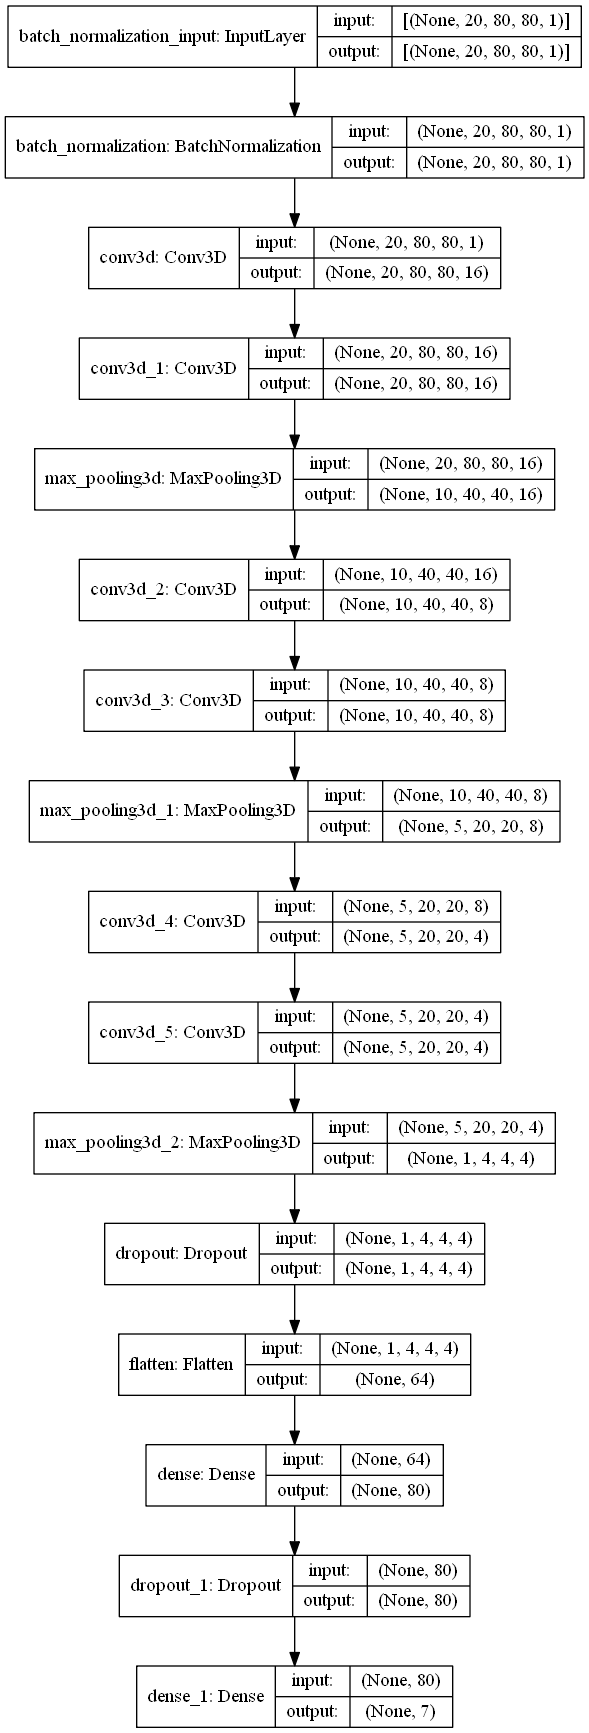

In [ ]:
dot_img_file = 'vkr/CNN/mode4.png'
tf.keras.utils.plot_model(model4, to_file=dot_img_file, show_shapes=True)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history_m4 = model4.fit(training_generator,
                    epochs=50,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
187/187 [==============================] - 107s 566ms/step - loss: 1.9308 - accuracy: 0.1720 - val_loss: 1.8916 - val_accuracy: 0.2143
Epoch 2/50
187/187 [==============================] - 106s 566ms/step - loss: 1.8950 - accuracy: 0.2386 - val_loss: 1.8340 - val_accuracy: 0.2999
Epoch 3/50
187/187 [==============================] - 106s 566ms/step - loss: 1.7973 - accuracy: 0.2908 - val_loss: 1.7298 - val_accuracy: 0.3229
Epoch 4/50
187/187 [==============================] - 106s 565ms/step - loss: 1.7434 - accuracy: 0.3212 - val_loss: 1.6836 - val_accuracy: 0.3296
Epoch 5/50
187/187 [==============================] - 106s 566ms/step - loss: 1.7123 - accuracy: 0.3392 - val_loss: 1.6487 - val_accuracy: 0.3750
Epoch 6/50
187/187 [==============================] - 106s 565ms/step - loss: 1.6637 - accuracy: 0.3581 - val_loss: 1.6201 - val_accuracy: 0.3914
Epoch 7/50
187/187 [==============================] - 106s 566ms/step - loss: 1.6474 - accuracy: 0.3580 - val_loss: 1.5853 -

Переобучения не видно, точность на валидационном наборе возрастает пропорциональнально обучающемуся. Дообучим модель с более мелким learning rate.

In [ ]:
model4.load_weights('vkr/CNN/CW_m4_2_10-0.53.hdf5')
model4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(1e-5), metrics=["accuracy"])

In [ ]:
history_m4_2 = model4.fit(training_generator,
                    epochs=50,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
187/187 [==============================] - 106s 566ms/step - loss: 1.1736 - accuracy: 0.5550 - val_loss: 1.2677 - val_accuracy: 0.5223
Epoch 2/50
187/187 [==============================] - 106s 566ms/step - loss: 1.1699 - accuracy: 0.5493 - val_loss: 1.2734 - val_accuracy: 0.5223
Epoch 3/50
187/187 [==============================] - 106s 566ms/step - loss: 1.1658 - accuracy: 0.5520 - val_loss: 1.2717 - val_accuracy: 0.5231
Epoch 4/50
187/187 [==============================] - 106s 566ms/step - loss: 1.1641 - accuracy: 0.5543 - val_loss: 1.2759 - val_accuracy: 0.5208
Epoch 5/50
187/187 [==============================] - 106s 566ms/step - loss: 1.1845 - accuracy: 0.5491 - val_loss: 1.2696 - val_accuracy: 0.5283
Epoch 6/50
187/187 [==============================] - 106s 566ms/step - loss: 1.1776 - accuracy: 0.5486 - val_loss: 1.2726 - val_accuracy: 0.5268
Epoch 7/50
187/187 [==============================] - 106s 567ms/step - loss: 1.1809 - accuracy: 0.5501 - val_loss: 1.2689 -

Отыграли всего один процент, попробуем изменить размер батча.

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_bs16_lr_e-5_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
history_m4_bs16 = model4.fit(training_generator,
                    epochs=50,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
375/375 [==============================] - 118s 313ms/step - loss: 1.2136 - accuracy: 0.5395 - val_loss: 1.2699 - val_accuracy: 0.5260
Epoch 2/50
375/375 [==============================] - 117s 313ms/step - loss: 1.2216 - accuracy: 0.5327 - val_loss: 1.2637 - val_accuracy: 0.5260
Epoch 3/50
375/375 [==============================] - 117s 313ms/step - loss: 1.2196 - accuracy: 0.5377 - val_loss: 1.2720 - val_accuracy: 0.5246
Epoch 4/50
375/375 [==============================] - 117s 313ms/step - loss: 1.2207 - accuracy: 0.5377 - val_loss: 1.2776 - val_accuracy: 0.5208
Epoch 5/50
375/375 [==============================] - 117s 313ms/step - loss: 1.2260 - accuracy: 0.5303 - val_loss: 1.2735 - val_accuracy: 0.5253
Epoch 6/50
375/375 [==============================] - 118s 313ms/step - loss: 1.2260 - accuracy: 0.5315 - val_loss: 1.2758 - val_accuracy: 0.5201
Epoch 7/50
375/375 [==============================] - 118s 313ms/step - loss: 1.2083 - accuracy: 0.5468 - val_loss: 1.2714 -

In [ ]:
round(model.optimizer.lr.numpy(), 15)

1e-04

Уменьшение размера батча не помогает, попробуем увеличить до 64.

In [ ]:
history_m4_bs64 = model4.fit(training_generator,
                    epochs=50,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/50
93/93 [==============================] - 151s 1s/step - loss: 1.1521 - accuracy: 0.5635 - val_loss: 1.2690 - val_accuracy: 0.5275
Epoch 2/50
93/93 [==============================] - 104s 1s/step - loss: 1.1406 - accuracy: 0.5642 - val_loss: 1.2698 - val_accuracy: 0.5283
Epoch 3/50
93/93 [==============================] - 104s 1s/step - loss: 1.1382 - accuracy: 0.5627 - val_loss: 1.2706 - val_accuracy: 0.5275
Epoch 4/50
93/93 [==============================] - 104s 1s/step - loss: 1.1463 - accuracy: 0.5596 - val_loss: 1.2709 - val_accuracy: 0.5275
Epoch 5/50
93/93 [==============================] - 104s 1s/step - loss: 1.1527 - accuracy: 0.5610 - val_loss: 1.2697 - val_accuracy: 0.5238
Epoch 6/50
93/93 [==============================] - 104s 1s/step - loss: 1.1475 - accuracy: 0.5586 - val_loss: 1.2715 - val_accuracy: 0.5246
Epoch 7/50
93/93 [==============================] - 104s 1s/step - loss: 1.1451 - accuracy: 0.5576 - val_loss: 1.2682 - val_accuracy: 0.5298
Epoch 8/50
93

Гипотеза, что размер батча повлияет на итоговую точность не  подтвердилась. Попробуем поиграть с оптимайзерами.

## model5 = model4 Nadam

In [ ]:
model5=model4
model5.load_weights('vkr/CNN/CW_m4_2_10-0.53.hdf5')
model5.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-3), metrics=["accuracy"])
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_bs16_Nadam_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_m5_bs16_Nadam = model5.fit(training_generator,
                    epochs=100,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/100
375/375 [==============================] - 119s 315ms/step - loss: 1.4027 - accuracy: 0.4620 - val_loss: 1.3589 - val_accuracy: 0.4874
Epoch 2/100
375/375 [==============================] - 118s 315ms/step - loss: 1.4123 - accuracy: 0.4588 - val_loss: 1.4205 - val_accuracy: 0.4680
Epoch 3/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4022 - accuracy: 0.4648 - val_loss: 1.4341 - val_accuracy: 0.4539
Epoch 4/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4093 - accuracy: 0.4608 - val_loss: 1.4007 - val_accuracy: 0.4650
Epoch 5/100
375/375 [==============================] - 118s 315ms/step - loss: 1.4006 - accuracy: 0.4662 - val_loss: 1.3363 - val_accuracy: 0.4896
Epoch 6/100
375/375 [==============================] - 118s 314ms/step - loss: 1.3798 - accuracy: 0.4680 - val_loss: 1.3765 - val_accuracy: 0.4814
Epoch 7/100
375/375 [==============================] - 118s 314ms/step - loss: 1.3549 - accuracy: 0.4793 - val_loss: 1

In [ ]:
saveHist('vkr/CNN/history_m5_bs16_Nadam.json', history_m5_bs16_Nadam.history)

In [ ]:
model5.load_weights('vkr/CNN/CW_m5_bs32_Nadam_29-0.58.hdf5')
model5.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-7), metrics=["accuracy"])
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m5_3_bs32_Nadam_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_m5_3_bs32_Nadam = model5.fit(training_generator,
                    epochs=100,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/100
187/187 [==============================] - 108s 569ms/step - loss: 1.0063 - accuracy: 0.6170 - val_loss: 1.1767 - val_accuracy: 0.5692
Epoch 2/100
187/187 [==============================] - 106s 568ms/step - loss: 1.0114 - accuracy: 0.6131 - val_loss: 1.1728 - val_accuracy: 0.5707
Epoch 3/100
187/187 [==============================] - 106s 568ms/step - loss: 1.0027 - accuracy: 0.6145 - val_loss: 1.1722 - val_accuracy: 0.5714
Epoch 4/100
187/187 [==============================] - 106s 568ms/step - loss: 1.0062 - accuracy: 0.6140 - val_loss: 1.1704 - val_accuracy: 0.5729
Epoch 5/100
187/187 [==============================] - 106s 568ms/step - loss: 1.0038 - accuracy: 0.6120 - val_loss: 1.1677 - val_accuracy: 0.5707
Epoch 6/100
187/187 [==============================] - 106s 567ms/step - loss: 0.9862 - accuracy: 0.6207 - val_loss: 1.1740 - val_accuracy: 0.5722
Epoch 7/100
187/187 [==============================] - 106s 568ms/step - loss: 0.9995 - accuracy: 0.6153 - val_loss: 1

In [ ]:
round(model.optimizer.lr.numpy(), 15)

1e-05

In [ ]:
saveHist('vkr/CNN/history_m5_2_bs32_Nadam.json', history_m5_2_bs32_Nadam.history)

Та же архитектура сети но с оптимайзером Nadam достигает точности 57%. Уже лучше, чем c Adam. Проверим, как сработает RMSprop

## model6 = model4 RMSprop

In [ ]:
model6=model4
model6.load_weights('vkr/CNN/CW_m4_2_10-0.53.hdf5')
model6.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(1e-3), metrics=["accuracy"])
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_bs16_RMSprop_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history_m6_bs16_RMSprop = model6.fit(training_generator,
                    epochs=100,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/100
375/375 [==============================] - 119s 315ms/step - loss: 1.4184 - accuracy: 0.4592 - val_loss: 1.4009 - val_accuracy: 0.4762
Epoch 2/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4442 - accuracy: 0.4498 - val_loss: 1.4640 - val_accuracy: 0.4345
Epoch 3/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4593 - accuracy: 0.4498 - val_loss: 1.4532 - val_accuracy: 0.4420
Epoch 4/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4558 - accuracy: 0.4508 - val_loss: 1.4267 - val_accuracy: 0.4613
Epoch 5/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4603 - accuracy: 0.4485 - val_loss: 1.4473 - val_accuracy: 0.4472
Epoch 6/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4267 - accuracy: 0.4567 - val_loss: 1.3942 - val_accuracy: 0.4814
Epoch 7/100
375/375 [==============================] - 118s 314ms/step - loss: 1.4000 - accuracy: 0.4640 - val_loss: 1

Модель с оптимайзером RMSprop тоже добралась до 57%, но в два раза медленнее, чем с Nadam (46 эпоха против 23). Что позволяет сделать выбор в пользу оптимайзера Nadam. Следующим шагом проверим гипотезу, что увеличение количества нейронов (до 128) в полносвязном слое приведет к росту точности модели.

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_d1_d128_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

## model4_d1_d128

In [ ]:
model4_d1_d128 = Sequential()
model4_d1_d128.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4_d1_d128.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4_d1_d128.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4_d1_d128.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d1_d128.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4_d1_d128.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4_d1_d128.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d1_d128.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4_d1_d128.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4_d1_d128.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
model4_d1_d128.add(Dropout(0.25)) # Слой регуляризации Dropout
model4_d1_d128.add(Flatten())
model4_d1_d128.add(Dense(128, activation='relu'))# Полносвязный слой для классификации
model4_d1_d128.add(Dropout(0.25))# Слой регуляризации Dropout
model4_d1_d128.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4_d1_d128.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

In [ ]:
history_m4_d1_d128 = model4_d1_d128.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

Epoch 1/150
187/187 [==============================] - 108s 569ms/step - loss: 1.9438 - accuracy: 0.1676 - val_loss: 1.9293 - val_accuracy: 0.1875
Epoch 2/150
187/187 [==============================] - 106s 568ms/step - loss: 1.8685 - accuracy: 0.2615 - val_loss: 1.7665 - val_accuracy: 0.3162
Epoch 3/150
187/187 [==============================] - 106s 567ms/step - loss: 1.7662 - accuracy: 0.3080 - val_loss: 1.6709 - val_accuracy: 0.3371
Epoch 4/150
187/187 [==============================] - 106s 568ms/step - loss: 1.7171 - accuracy: 0.3277 - val_loss: 1.6309 - val_accuracy: 0.3757
Epoch 5/150
187/187 [==============================] - 106s 567ms/step - loss: 1.6689 - accuracy: 0.3581 - val_loss: 1.5975 - val_accuracy: 0.3780
Epoch 6/150
187/187 [==============================] - 106s 568ms/step - loss: 1.6247 - accuracy: 0.3693 - val_loss: 1.5544 - val_accuracy: 0.4040
Epoch 7/150
187/187 [==============================] - 106s 567ms/step - loss: 1.5854 - accuracy: 0.3910 - val_loss: 1

In [ ]:
print(round(model4_d1_d128.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d1_d128_Nadam_1_150.json', history_m4_d1_d128.history)

8.31522e-10


На процент точность повысилась (достигла 58%). Уменьшим параметр второго слоя Dropout до 0,1

## model4_d2_d128_do01

In [ ]:
model4_d2_d128_do01 = Sequential()
model4_d2_d128_do01.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4_d2_d128_do01.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4_d2_d128_do01.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4_d2_d128_do01.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d2_d128_do01.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4_d2_d128_do01.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4_d2_d128_do01.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d2_d128_do01.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4_d2_d128_do01.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4_d2_d128_do01.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
model4_d2_d128_do01.add(Dropout(0.25)) # Слой регуляризации Dropout
model4_d2_d128_do01.add(Flatten())
model4_d2_d128_do01.add(Dense(128, activation='relu'))# Полносвязный слой для классификации
model4_d2_d128_do01.add(Dropout(0.1))# Слой регуляризации Dropout
model4_d2_d128_do01.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4_d2_d128_do01.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_d2_d128_do01_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_d2_d128_do01 = model4_d2_d128_do01.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d2_d128_do01.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d2_d128_do01_1_150.json', history_m4_d2_d128_do01.history)

Epoch 1/150
187/187 [==============================] - 108s 568ms/step - loss: 1.9638 - accuracy: 0.1656 - val_loss: 1.9435 - val_accuracy: 0.1592
Epoch 2/150
187/187 [==============================] - 106s 567ms/step - loss: 1.8969 - accuracy: 0.2086 - val_loss: 1.8386 - val_accuracy: 0.2619
Epoch 3/150
187/187 [==============================] - 106s 567ms/step - loss: 1.8338 - accuracy: 0.2664 - val_loss: 1.7527 - val_accuracy: 0.3192
Epoch 4/150
187/187 [==============================] - 106s 567ms/step - loss: 1.8090 - accuracy: 0.2923 - val_loss: 1.7190 - val_accuracy: 0.3296
Epoch 5/150
187/187 [==============================] - 106s 567ms/step - loss: 1.7287 - accuracy: 0.3234 - val_loss: 1.6065 - val_accuracy: 0.3780
Epoch 6/150
187/187 [==============================] - 106s 567ms/step - loss: 1.6776 - accuracy: 0.3468 - val_loss: 1.5633 - val_accuracy: 0.4234
Epoch 7/150
187/187 [==============================] - 106s 567ms/step - loss: 1.6210 - accuracy: 0.3792 - val_loss: 1

Итог отрицательный, точность падает. Рассмотрим сеть с полносвязным слоем, увеличенным до 256 нейронов

## model4_d256

In [ ]:
model4_d256 = Sequential()
model4_d256.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4_d256.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4_d256.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4_d256.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d256.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4_d256.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4_d256.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d256.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4_d256.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4_d256.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model4_d256.add(Dropout(0.25)) # Слой регуляризации Dropout
model4_d256.add(Flatten())
model4_d256.add(BatchNormalization())
model4_d256.add(Dense(256, activation='relu'))# Полносвязный слой для классификации
model4_d256.add(Dropout(0.25))# Слой регуляризации Dropout
model4_d256.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4_d256.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m4_d256_w1do_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_d256 = model4_d256.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d256.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d256.json', history_m4_d256.history)

Epoch 1/150
187/187 [==============================] - 108s 570ms/step - loss: 1.7641 - accuracy: 0.3185 - val_loss: 1.6571 - val_accuracy: 0.3542
Epoch 2/150
187/187 [==============================] - 106s 568ms/step - loss: 1.5578 - accuracy: 0.4151 - val_loss: 1.4984 - val_accuracy: 0.4338
Epoch 3/150
187/187 [==============================] - 106s 568ms/step - loss: 1.4705 - accuracy: 0.4512 - val_loss: 1.4137 - val_accuracy: 0.4792
Epoch 4/150
187/187 [==============================] - 106s 569ms/step - loss: 1.3855 - accuracy: 0.4860 - val_loss: 1.4580 - val_accuracy: 0.4725
Epoch 5/150
187/187 [==============================] - 106s 569ms/step - loss: 1.3298 - accuracy: 0.5047 - val_loss: 1.2565 - val_accuracy: 0.5484
Epoch 6/150
187/187 [==============================] - 106s 569ms/step - loss: 1.2597 - accuracy: 0.5349 - val_loss: 1.2314 - val_accuracy: 0.5588
Epoch 7/150
187/187 [==============================] - 106s 569ms/step - loss: 1.2258 - accuracy: 0.5431 - val_loss: 1

На 10% добавили в точности, попробуем дообучить

In [ ]:

model4_d256.load_weights('vkr/CNN/m4_d256_w1do_94-0.68.hdf5')
model4_d256.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m4_2_d256_w1do_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_2_d256 = model4_d256.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d256.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_2_d256.json', history_m4_2_d256.history)

Epoch 1/150
187/187 [==============================] - 108s 569ms/step - loss: 0.8266 - accuracy: 0.6980 - val_loss: 0.9525 - val_accuracy: 0.6510
Epoch 2/150
187/187 [==============================] - 106s 568ms/step - loss: 0.8263 - accuracy: 0.6970 - val_loss: 0.9842 - val_accuracy: 0.6577
Epoch 3/150
187/187 [==============================] - 106s 568ms/step - loss: 0.8104 - accuracy: 0.7039 - val_loss: 0.9032 - val_accuracy: 0.6682
Epoch 4/150
187/187 [==============================] - 106s 568ms/step - loss: 0.8226 - accuracy: 0.7014 - val_loss: 0.9001 - val_accuracy: 0.6682
Epoch 5/150
187/187 [==============================] - 106s 568ms/step - loss: 0.8035 - accuracy: 0.7137 - val_loss: 0.8936 - val_accuracy: 0.6734
Epoch 6/150
187/187 [==============================] - 106s 568ms/step - loss: 0.7845 - accuracy: 0.7112 - val_loss: 0.9178 - val_accuracy: 0.6555
Epoch 7/150
187/187 [==============================] - 106s 568ms/step - loss: 0.7721 - accuracy: 0.7198 - val_loss: 0

Точность растет, на основании подверждения гипотезы, увеличиваем полносвязный слой до 512 нейронов

## model4_d512_wdo

In [ ]:
model4_d512_wdo = Sequential()
model4_d512_wdo.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4_d512_wdo.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4_d512_wdo.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4_d512_wdo.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d512_wdo.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4_d512_wdo.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4_d512_wdo.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d512_wdo.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4_d512_wdo.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4_d512_wdo.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model4_d512_wdo.add(Dropout(0.25)) # Слой регуляризации Dropout
model4_d512_wdo.add(Flatten())
model4_d512_wdo.add(BatchNormalization())
model4_d512_wdo.add(Dense(512, activation='relu'))# Полносвязный слой для классификации
model4_d512_wdo.add(Dropout(0.3))# Слой регуляризации Dropout
model4_d512_wdo.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4_d512_wdo.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_d512_wdo_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_d512_wdo = model4_d512_wdo.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d512_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d512_wdo.json', history_m4_d512_wdo.history)

Epoch 1/150
187/187 [==============================] - 108s 569ms/step - loss: 1.7471 - accuracy: 0.3172 - val_loss: 1.7487 - val_accuracy: 0.3423
Epoch 2/150
187/187 [==============================] - 106s 568ms/step - loss: 1.5276 - accuracy: 0.4196 - val_loss: 1.5352 - val_accuracy: 0.4249
Epoch 3/150
187/187 [==============================] - 106s 568ms/step - loss: 1.3957 - accuracy: 0.4830 - val_loss: 1.4516 - val_accuracy: 0.4836
Epoch 4/150
187/187 [==============================] - 106s 568ms/step - loss: 1.3080 - accuracy: 0.5119 - val_loss: 1.3893 - val_accuracy: 0.5119
Epoch 5/150
187/187 [==============================] - 106s 568ms/step - loss: 1.2177 - accuracy: 0.5551 - val_loss: 1.2180 - val_accuracy: 0.5677
Epoch 6/150
187/187 [==============================] - 106s 568ms/step - loss: 1.1638 - accuracy: 0.5734 - val_loss: 1.2353 - val_accuracy: 0.5677
Epoch 7/150
187/187 [==============================] - 106s 568ms/step - loss: 1.1189 - accuracy: 0.5896 - val_loss: 1

In [ ]:

model4_d512_wdo.load_weights('vkr/CNN/CW_m4_d512_wdo_49-0.74.hdf5')
model4_d512_wdo.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-5), metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_2_d512_wdo_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_2_d512_wdo = model4_d512_wdo.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(odel4_d512_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_2_d512_wdo.json', history_m4_2_d512_wdo.history)

Epoch 1/150
187/187 [==============================] - 108s 570ms/step - loss: 0.5508 - accuracy: 0.8041 - val_loss: 0.7830 - val_accuracy: 0.7344
Epoch 2/150
187/187 [==============================] - 106s 569ms/step - loss: 0.5353 - accuracy: 0.8133 - val_loss: 0.7840 - val_accuracy: 0.7329
Epoch 3/150
187/187 [==============================] - 106s 569ms/step - loss: 0.5404 - accuracy: 0.8097 - val_loss: 0.7828 - val_accuracy: 0.7314
Epoch 4/150
187/187 [==============================] - 106s 569ms/step - loss: 0.5292 - accuracy: 0.8204 - val_loss: 0.7805 - val_accuracy: 0.7336
Epoch 5/150
187/187 [==============================] - 106s 569ms/step - loss: 0.5334 - accuracy: 0.8095 - val_loss: 0.7730 - val_accuracy: 0.7351
Epoch 6/150
187/187 [==============================] - 106s 569ms/step - loss: 0.5348 - accuracy: 0.8190 - val_loss: 0.7813 - val_accuracy: 0.7336
Epoch 7/150
187/187 [==============================] - 106s 569ms/step - loss: 0.5325 - accuracy: 0.8158 - val_loss: 0

NameError: name 'odel4_d512_wdo' is not defined

In [ ]:
print(round(model4_d512_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_2_d512_wdo.json', history_m4_2_d512_wdo.history)

1.1108969e-07


Дообучение не привело к улучшению результата в 74%. Наращиваем Dense до 1024 нейронов.

## model4_d1024_wdo

In [ ]:
model4_d1024_wdo = Sequential()
model4_d1024_wdo.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4_d1024_wdo.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4_d1024_wdo.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4_d1024_wdo.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d1024_wdo.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4_d1024_wdo.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4_d1024_wdo.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d1024_wdo.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4_d1024_wdo.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4_d1024_wdo.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model4_d1024_wdo.add(Dropout(0.25)) # Слой регуляризации Dropout
model4_d1024_wdo.add(Flatten())
model4_d1024_wdo.add(BatchNormalization())
model4_d1024_wdo.add(Dense(1024, activation='relu'))# Полносвязный слой для классификации
model4_d1024_wdo.add(Dropout(0.3))# Слой регуляризации Dropout
model4_d1024_wdo.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4_d1024_wdo.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_d1024_wdo_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_d1024_wdo = model4_d1024_wdo.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d1024_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d1024_wdo.json', history_m4_d1024_wdo.history)

Epoch 1/150
187/187 [==============================] - 108s 569ms/step - loss: 1.6803 - accuracy: 0.3576 - val_loss: 1.6218 - val_accuracy: 0.3862
Epoch 2/150
187/187 [==============================] - 106s 568ms/step - loss: 1.4470 - accuracy: 0.4537 - val_loss: 1.3740 - val_accuracy: 0.4896
Epoch 3/150
187/187 [==============================] - 106s 568ms/step - loss: 1.3418 - accuracy: 0.5087 - val_loss: 1.2812 - val_accuracy: 0.5327
Epoch 4/150
187/187 [==============================] - 106s 568ms/step - loss: 1.2463 - accuracy: 0.5408 - val_loss: 1.2184 - val_accuracy: 0.5551
Epoch 5/150
187/187 [==============================] - 106s 568ms/step - loss: 1.1929 - accuracy: 0.5668 - val_loss: 1.1716 - val_accuracy: 0.5796
Epoch 6/150
187/187 [==============================] - 106s 568ms/step - loss: 1.1398 - accuracy: 0.5804 - val_loss: 1.1176 - val_accuracy: 0.5722
Epoch 7/150
187/187 [==============================] - 106s 568ms/step - loss: 1.0819 - accuracy: 0.5971 - val_loss: 1

KeyboardInterrupt: 

На 55 эпохе обучения выскочила ощшибка колбэка, загрузим полученные лучшие веса, продолжим обучать модель

In [ ]:
model4_d1024_wdo.load_weights('vkr/CNN/CW_m4_d1024_wdo_42-0.76.hdf5')
model4_d1024_wdo.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-5), metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_2_d1024_wdo_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_2_d1024_wdo = model4_d1024_wdo.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d1024_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_2_d1024_wdo.json', history_m4_2_d1024_wdo.history)

Epoch 1/150
187/187 [==============================] - 108s 569ms/step - loss: 0.4809 - accuracy: 0.8305 - val_loss: 0.7231 - val_accuracy: 0.7515
Epoch 2/150
187/187 [==============================] - 106s 569ms/step - loss: 0.4846 - accuracy: 0.8235 - val_loss: 0.7212 - val_accuracy: 0.7515
Epoch 3/150
187/187 [==============================] - 106s 569ms/step - loss: 0.4775 - accuracy: 0.8307 - val_loss: 0.7249 - val_accuracy: 0.7485
Epoch 4/150
187/187 [==============================] - 106s 569ms/step - loss: 0.4818 - accuracy: 0.8282 - val_loss: 0.7222 - val_accuracy: 0.7493
Epoch 5/150
187/187 [==============================] - 106s 569ms/step - loss: 0.4801 - accuracy: 0.8339 - val_loss: 0.7204 - val_accuracy: 0.7493
Epoch 6/150
187/187 [==============================] - 106s 569ms/step - loss: 0.4782 - accuracy: 0.8346 - val_loss: 0.7236 - val_accuracy: 0.7500
Epoch 7/150
187/187 [==============================] - 106s 569ms/step - loss: 0.4774 - accuracy: 0.8347 - val_loss: 0

Выше 76% точности получить не удалось, продолжим экстенсивный путь, увеличим число нейронов в Dense слое до 1500

## model4_d1500

In [ ]:
model4_d1500_wdo = Sequential()
model4_d1500_wdo.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model4_d1500_wdo.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Первый сверточный слой
model4_d1500_wdo.add(Conv3D(16, (7, 7, 7), padding='same', activation='relu')) # Второй сверточный слой
model4_d1500_wdo.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d1500_wdo.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Первый сверточный слой
model4_d1500_wdo.add(Conv3D(8, (5, 5, 5), padding='same', activation='relu')) # Второй сверточный слой
model4_d1500_wdo.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model4_d1500_wdo.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Первый сверточный слой
model4_d1500_wdo.add(Conv3D(4, (3, 3, 3), padding='same', activation='relu')) # Второй сверточный слой
model4_d1500_wdo.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model4_d1500_wdo.add(Dropout(0.25)) # Слой регуляризации Dropout
model4_d1500_wdo.add(Flatten())
model4_d1500_wdo.add(BatchNormalization())
model4_d1500_wdo.add(Dense(1500, activation='relu'))# Полносвязный слой для классификации
model4_d1500_wdo.add(Dropout(0.3))# Слой регуляризации Dropout
model4_d1500_wdo.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model4_d1500_wdo.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/CW_m4_d1500_wdo_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m4_d1500_wdo = model4_d1500_wdo.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model4_d1500_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d1500_wdo.json', history_m4_d1500_wdo.history)

Epoch 1/150
187/187 [==============================] - 108s 570ms/step - loss: 1.6929 - accuracy: 0.3523 - val_loss: 1.7432 - val_accuracy: 0.3013
Epoch 2/150
187/187 [==============================] - 106s 569ms/step - loss: 1.4464 - accuracy: 0.4619 - val_loss: 1.5406 - val_accuracy: 0.4226
Epoch 3/150
187/187 [==============================] - 106s 569ms/step - loss: 1.3330 - accuracy: 0.5107 - val_loss: 1.3329 - val_accuracy: 0.4970
Epoch 4/150
187/187 [==============================] - 106s 569ms/step - loss: 1.2537 - accuracy: 0.5353 - val_loss: 1.2397 - val_accuracy: 0.5402
Epoch 5/150
187/187 [==============================] - 106s 568ms/step - loss: 1.1627 - accuracy: 0.5740 - val_loss: 1.2182 - val_accuracy: 0.5565
Epoch 6/150
187/187 [==============================] - 106s 569ms/step - loss: 1.1220 - accuracy: 0.5889 - val_loss: 1.1536 - val_accuracy: 0.5632
Epoch 7/150
187/187 [==============================] - 106s 569ms/step - loss: 1.0642 - accuracy: 0.6173 - val_loss: 1

In [ ]:
print(round(model4_d1500_wdo.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m4_d1500_wdo.json', history_m4_d1500_wdo.history)

1.515133e-09


Результат не радует, точность понизилась. Подумав о характере входных данных сети я решила, что лицо человека обладает определенной симметричностью и может сработать идея о замене нечетных чисел в ядрах сверток на четные. Выберем в сверточных блоках ядра сверток 8, 6 и 4 соответственно

## model5_864

In [ ]:
model5_864 = Sequential()
model5_864.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model5_864.add(Conv3D(16, (8, 8, 8), padding='same', activation='relu')) # Первый сверточный слой
model5_864.add(Conv3D(16, (8, 8, 8), padding='same', activation='relu')) # Второй сверточный слой
model5_864.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model5_864.add(Conv3D(8, (6, 6, 6), padding='same', activation='relu')) # Первый сверточный слой
model5_864.add(Conv3D(8, (6, 6, 6), padding='same', activation='relu')) # Второй сверточный слой
model5_864.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model5_864.add(Conv3D(4, (4, 4, 4), padding='same', activation='relu')) # Первый сверточный слой
model5_864.add(Conv3D(4, (4, 4, 4), padding='same', activation='relu')) # Второй сверточный слой
model5_864.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model5_864.add(Dropout(0.25)) # Слой регуляризации Dropout
model5_864.add(Flatten())
model5_864.add(BatchNormalization())
model5_864.add(Dense(1500, activation='relu'))# Полносвязный слой для классификации
model5_864.add(Dropout(0.3))# Слой регуляризации Dropout
model5_864.add(Dense(7, activation='softmax')) # Выходной полносвязный слой

model5_864.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m5_864_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m5_864 = model5_864.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model5_864.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m5_864.json', history_m5_864.history)

Epoch 1/150
187/187 [==============================] - 195s 862ms/step - loss: 1.6734 - accuracy: 0.3643 - val_loss: 1.5710 - val_accuracy: 0.4003
Epoch 2/150
187/187 [==============================] - 161s 861ms/step - loss: 1.4040 - accuracy: 0.4816 - val_loss: 1.4111 - val_accuracy: 0.4717
Epoch 3/150
187/187 [==============================] - 161s 861ms/step - loss: 1.2687 - accuracy: 0.5399 - val_loss: 1.2497 - val_accuracy: 0.5499
Epoch 4/150
187/187 [==============================] - 161s 861ms/step - loss: 1.1705 - accuracy: 0.5699 - val_loss: 1.1811 - val_accuracy: 0.5521
Epoch 5/150
187/187 [==============================] - 161s 861ms/step - loss: 1.0808 - accuracy: 0.6106 - val_loss: 1.1186 - val_accuracy: 0.6027
Epoch 6/150
187/187 [==============================] - 161s 861ms/step - loss: 1.0073 - accuracy: 0.6344 - val_loss: 1.1198 - val_accuracy: 0.5811
Epoch 7/150
187/187 [==============================] - 161s 861ms/step - loss: 0.9455 - accuracy: 0.6576 - val_loss: 1

Точность повысилась до устойчивых 78%. Добавим еще один полносвязный слой.

## model5_864_3d

In [ ]:
model5_864_3d = Sequential()
model5_864_3d.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model5_864_3d.add(Conv3D(16, (8, 8, 8), padding='same', activation='relu')) # Первый сверточный слой
model5_864_3d.add(Conv3D(16, (8, 8, 8), padding='same', activation='relu')) # Второй сверточный слой
model5_864_3d.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model5_864_3d.add(Conv3D(8, (6, 6, 6), padding='same', activation='relu')) # Первый сверточный слой
model5_864_3d.add(Conv3D(8, (6, 6, 6), padding='same', activation='relu')) # Второй сверточный слой
model5_864_3d.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model5_864_3d.add(Conv3D(4, (4, 4, 4), padding='same', activation='relu')) # Первый сверточный слой
model5_864_3d.add(Conv3D(4, (4, 4, 4), padding='same', activation='relu')) # Второй сверточный слой
model5_864_3d.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model5_864_3d.add(Dropout(0.25)) # Слой регуляризации Dropout
model5_864_3d.add(Flatten())
model5_864_3d.add(BatchNormalization())
model5_864_3d.add(Dense(1500, activation='relu'))# Полносвязный слой для классификации
model5_864_3d.add(Dropout(0.3))# Слой регуляризации Dropout
model5_864_3d.add(Dense(256, activation='relu'))# Полносвязный слой для классификации
model5_864_3d.add(Dropout(0.1))# Слой регуляризации Dropout
model5_864_3d.add(Dense(7, activation='softmax')) # Выходной полносвязный слой
model5_864_3d.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m5_864_3d_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m5_864_3d = model5_864_3d.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model5_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m5_864_3d.json', history_m5_864_3d.history)

Epoch 1/150
187/187 [==============================] - 163s 863ms/step - loss: 1.6659 - accuracy: 0.3630 - val_loss: 1.5533 - val_accuracy: 0.3914
Epoch 2/150
187/187 [==============================] - 161s 862ms/step - loss: 1.3542 - accuracy: 0.4880 - val_loss: 1.2347 - val_accuracy: 0.5327
Epoch 3/150
187/187 [==============================] - 161s 862ms/step - loss: 1.1658 - accuracy: 0.5647 - val_loss: 1.2705 - val_accuracy: 0.5424
Epoch 4/150
187/187 [==============================] - 161s 862ms/step - loss: 1.0472 - accuracy: 0.6071 - val_loss: 1.0963 - val_accuracy: 0.5900
Epoch 5/150
187/187 [==============================] - 161s 862ms/step - loss: 0.9648 - accuracy: 0.6359 - val_loss: 1.0156 - val_accuracy: 0.6257
Epoch 6/150
187/187 [==============================] - 161s 862ms/step - loss: 0.8861 - accuracy: 0.6730 - val_loss: 1.1266 - val_accuracy: 0.6094
Epoch 7/150
187/187 [==============================] - 161s 862ms/step - loss: 0.8044 - accuracy: 0.6954 - val_loss: 0

In [ ]:
print(round(model5_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m5_864_3d.json', history_m5_864_3d.history)

2.2428599e-06


In [ ]:
history_m5_864_3d.history['lr'][25]

0.00033287084

In [ ]:
history_m5_864_3d.history['val_accuracy'][49]

0.8184523582458496

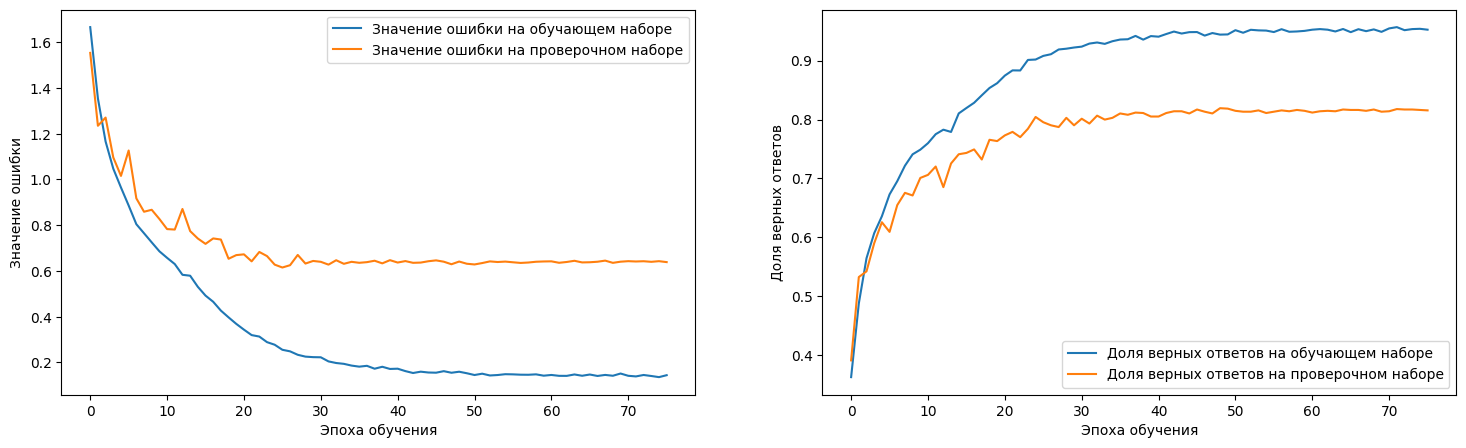

In [ ]:
plot_history(history_m5_864_3d.history)

Точность выросла до 82%. Попробуем увеличить размер батча и дообучить сеть.

In [ ]:
training_generator = DataGenerator('Train',listID_train, 128)
validation_generator = DataGenerator('Val',listID_val,128)

In [ ]:
model5_864_3d.load_weights('vkr/CNN/m5_864_3d_2_04-0.82.hdf5')
model5_864_3d.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-5), metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m5_864_3d_3_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history_m5_864_3d_3 = model5_864_3d.fit(training_generator,
                    epochs=50,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model5_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m5_864_3d_3.json', history_m5_864_3d_3.history)

Epoch 1/50
46/46 [==============================] - 294s 3s/step - loss: 0.1055 - accuracy: 0.9677 - val_loss: 0.6319 - val_accuracy: 0.8177
Epoch 2/50
46/46 [==============================] - 154s 3s/step - loss: 0.1019 - accuracy: 0.9677 - val_loss: 0.6323 - val_accuracy: 0.8140
Epoch 3/50
46/46 [==============================] - 155s 3s/step - loss: 0.1070 - accuracy: 0.9672 - val_loss: 0.6273 - val_accuracy: 0.8162
Epoch 4/50
46/46 [==============================] - 154s 3s/step - loss: 0.1010 - accuracy: 0.9665 - val_loss: 0.6333 - val_accuracy: 0.8132
Epoch 5/50
46/46 [==============================] - 154s 3s/step - loss: 0.1020 - accuracy: 0.9693 - val_loss: 0.6302 - val_accuracy: 0.8140
Epoch 6/50
46/46 [==============================] - 154s 3s/step - loss: 0.1021 - accuracy: 0.9686 - val_loss: 0.6296 - val_accuracy: 0.8140
Epoch 7/50
46/46 [==============================] - 154s 3s/step - loss: 0.1085 - accuracy: 0.9662 - val_loss: 0.6350 - val_accuracy: 0.8125
Epoch 8/50
46

KeyboardInterrupt: 

Идея не сработала, результат не улучшился. Поменяем структуру еще раз. Установим возрастающее число нейронов в сверточных блоках - чем мельче окно свертки, тем больше нейронов на слой. И уменьшим размеры полносвязных слоев.

## model6_864_3d 512-128-7

In [ ]:
model6_864_3d = Sequential()
model6_864_3d.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model6_864_3d.add(Conv3D(8, (8, 8, 8), padding='same', activation='relu')) # Первый сверточный слой
model6_864_3d.add(Conv3D(8, (8, 8, 8), padding='same', activation='relu')) # Второй сверточный слой
model6_864_3d.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model6_864_3d.add(Conv3D(16, (6, 6, 6), padding='same', activation='relu')) # Первый сверточный слой
model6_864_3d.add(Conv3D(16, (6, 6, 6), padding='same', activation='relu')) # Второй сверточный слой
model6_864_3d.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model6_864_3d.add(Conv3D(32, (4, 4, 4), padding='same', activation='relu')) # Первый сверточный слой
model6_864_3d.add(Conv3D(32, (4, 4, 4), padding='same', activation='relu')) # Второй сверточный слой
model6_864_3d.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
#model6_864_3d.add(Dropout(0.25)) # Слой регуляризации Dropout
model6_864_3d.add(Flatten())
model6_864_3d.add(BatchNormalization())
model6_864_3d.add(Dense(512, activation='relu'))# Полносвязный слой для классификации
model6_864_3d.add(Dropout(0.3))# Слой регуляризации Dropout
model6_864_3d.add(Dense(128, activation='relu'))# Полносвязный слой для классификации
model6_864_3d.add(Dropout(0.1))# Слой регуляризации Dropout
model6_864_3d.add(Dense(7, activation='softmax')) # Выходной полносвязный слой
model6_864_3d.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m6_864_3d_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m6_864_3d = model6_864_3d.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model6_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m6_864_3d.json', history_m6_864_3d.history)

Epoch 1/150
46/46 [==============================] - 97s 2s/step - loss: 1.8348 - accuracy: 0.2891 - val_loss: 1.9727 - val_accuracy: 0.1703
Epoch 2/150
46/46 [==============================] - 95s 2s/step - loss: 1.4952 - accuracy: 0.4421 - val_loss: 1.8759 - val_accuracy: 0.2273
Epoch 3/150
46/46 [==============================] - 95s 2s/step - loss: 1.3184 - accuracy: 0.5149 - val_loss: 1.8521 - val_accuracy: 0.2734
Epoch 4/150
46/46 [==============================] - 95s 2s/step - loss: 1.1593 - accuracy: 0.5667 - val_loss: 1.3364 - val_accuracy: 0.5016
Epoch 5/150
46/46 [==============================] - 96s 2s/step - loss: 1.0488 - accuracy: 0.6168 - val_loss: 1.2292 - val_accuracy: 0.5500
Epoch 6/150
46/46 [==============================] - 95s 2s/step - loss: 0.9460 - accuracy: 0.6559 - val_loss: 1.0680 - val_accuracy: 0.6125
Epoch 7/150
46/46 [==============================] - 95s 2s/step - loss: 0.8883 - accuracy: 0.6703 - val_loss: 1.0306 - val_accuracy: 0.6391
Epoch 8/150
4

In [ ]:
model6_864_3d.load_weights('vkr/CNN/m6_864_3d_61-0.82.hdf5')
model6_864_3d.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-5), metrics=["accuracy"]) # Компилируем сеть

def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m6_864_3d_2_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


history_m6_864_3d_2 = model6_864_3d.fit(training_generator,
                    epochs=150,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model6_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m6_864_3d_2.json', history_m6_864_3d_2.history)

Epoch 1/150
187/187 [==============================] - 122s 543ms/step - loss: 0.2466 - accuracy: 0.9139 - val_loss: 0.6450 - val_accuracy: 0.8162
Epoch 2/150
187/187 [==============================] - 101s 542ms/step - loss: 0.2278 - accuracy: 0.9213 - val_loss: 0.6496 - val_accuracy: 0.8185
Epoch 3/150
187/187 [==============================] - 101s 540ms/step - loss: 0.2267 - accuracy: 0.9164 - val_loss: 0.6410 - val_accuracy: 0.8177
Epoch 4/150
187/187 [==============================] - 101s 541ms/step - loss: 0.2221 - accuracy: 0.9230 - val_loss: 0.6493 - val_accuracy: 0.8177
Epoch 5/150
187/187 [==============================] - 101s 541ms/step - loss: 0.2410 - accuracy: 0.9113 - val_loss: 0.6422 - val_accuracy: 0.8207
Epoch 6/150
187/187 [==============================] - 101s 542ms/step - loss: 0.2194 - accuracy: 0.9251 - val_loss: 0.6381 - val_accuracy: 0.8192
Epoch 7/150
187/187 [==============================] - 101s 542ms/step - loss: 0.2291 - accuracy: 0.9183 - val_loss: 0

NameError: name 'saveHist' is not defined

In [ ]:
saveHist('vkr/CNN/history_m6_864_3d_2.json', history_m6_864_3d_2.history)

In [ ]:
history_m6_864_3d_2.history['val_accuracy'][13]

0.8258928656578064

In [ ]:
history_m6_864_3d_2.history['lr'][13]

1e-05

In [ ]:
print(round(model6_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m6_864_3d.json', history_m6_864_3d.history)
saveHist('vkr/CNN/history_m5_864_3d_2.json', history_m5_864_3d_2.history)

Дотянулись до 83% на 14 эпохе, но стабильно 82% точности. Попробуем добавить еще один сверточный блок на 64 нейрона с ядром свертки=2 после последнего макспуллинга.

## model7

In [ ]:
model7_864_3d = Sequential()
model7_864_3d.add(BatchNormalization(input_shape=(20, 80, 80, 1))) # Слой пакетной нормализации
model7_864_3d.add(Conv3D(8, (8, 8, 8), padding='same', activation='relu')) # Первый сверточный слой
model7_864_3d.add(Conv3D(8, (8, 8, 8), padding='same', activation='relu')) # Второй сверточный слой
model7_864_3d.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model7_864_3d.add(BatchNormalization())
model7_864_3d.add(Conv3D(16, (6, 6, 6), padding='same', activation='relu')) # Первый сверточный слой
model7_864_3d.add(Conv3D(16, (6, 6, 6), padding='same', activation='relu')) # Второй сверточный слой
model7_864_3d.add(MaxPooling3D(pool_size=(2, 2, 2))) # Первый слой подвыборки
model7_864_3d.add(BatchNormalization())
model7_864_3d.add(Conv3D(32, (4, 4, 4), padding='same', activation='relu')) # Первый сверточный слой
model7_864_3d.add(Conv3D(32, (4, 4, 4), padding='same', activation='relu')) # Второй сверточный слой
model7_864_3d.add(MaxPooling3D(pool_size=(5, 5, 5))) # Первый слой подвыборки
model7_864_3d.add(BatchNormalization())
model7_864_3d.add(Conv3D(64, (2, 2, 2), padding='same', activation='relu')) # Первый сверточный слой
model7_864_3d.add(Conv3D(64, (2, 2, 2), padding='same', activation='relu')) # Второй сверточный слой

#model7_864_3d.add(Dropout(0.25)) # Слой регуляризации Dropout
model7_864_3d.add(Flatten())
model7_864_3d.add(BatchNormalization())
model7_864_3d.add(Dense(512, activation='relu'))# Полносвязный слой для классификации
model7_864_3d.add(Dropout(0.3))# Слой регуляризации Dropout
model7_864_3d.add(Dense(128, activation='relu'))# Полносвязный слой для классификации
model7_864_3d.add(Dropout(0.1))# Слой регуляризации Dropout
model7_864_3d.add(Dense(7, activation='softmax')) # Выходной полносвязный слой
model7_864_3d.load_weights('vkr/CNN/m7_3_08-0.84.hdf5')
model7_864_3d.compile(loss="categorical_crossentropy", optimizer="Nadam", metrics=["accuracy"]) # Компилируем сеть

In [ ]:
history_m7 = model7_864_3d.fit(training_generator,
                    epochs=100,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model7_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m7.json', history_m7.history)

Epoch 1/100
187/187 [==============================] - 121s 546ms/step - loss: 1.7707 - accuracy: 0.3257 - val_loss: 1.7762 - val_accuracy: 0.3341
Epoch 2/100
187/187 [==============================] - 102s 544ms/step - loss: 1.4325 - accuracy: 0.4579 - val_loss: 1.6218 - val_accuracy: 0.3743
Epoch 3/100
187/187 [==============================] - 102s 544ms/step - loss: 1.2234 - accuracy: 0.5406 - val_loss: 1.4456 - val_accuracy: 0.4725
Epoch 4/100
187/187 [==============================] - 102s 544ms/step - loss: 1.1039 - accuracy: 0.5824 - val_loss: 1.4891 - val_accuracy: 0.4851
Epoch 5/100
187/187 [==============================] - 102s 545ms/step - loss: 0.9965 - accuracy: 0.6217 - val_loss: 1.4258 - val_accuracy: 0.4985
Epoch 6/100
187/187 [==============================] - 102s 545ms/step - loss: 0.9201 - accuracy: 0.6482 - val_loss: 1.0581 - val_accuracy: 0.6146
Epoch 7/100
187/187 [==============================] - 102s 545ms/step - loss: 0.8607 - accuracy: 0.6690 - val_loss: 1

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
clb_Lr_Shdl = tf.keras.callbacks.LearningRateScheduler(scheduler)

checkpoint_filepath = 'vkr/CNN/m7_2_{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only = True,
    monitor='val_accuracy',
    mode='max')
clb_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
model7_864_3d.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(1e-5), metrics=["accuracy"])

In [ ]:
history_m7_2 = model7_864_3d.fit(training_generator,
                    epochs=100,validation_data=validation_generator, callbacks=[clb_Lr_Shdl,model_checkpoint_callback,clb_stop])

print(round(model7_864_3d.optimizer.lr.numpy(), 15))
saveHist('vkr/CNN/history_m7_2.json', history_m7_2.history)

Epoch 1/100
187/187 [==============================] - 104s 546ms/step - loss: 0.0925 - accuracy: 0.9679 - val_loss: 0.7354 - val_accuracy: 0.8304
Epoch 2/100
187/187 [==============================] - 102s 545ms/step - loss: 0.1092 - accuracy: 0.9614 - val_loss: 0.7359 - val_accuracy: 0.8341
Epoch 3/100
187/187 [==============================] - 102s 544ms/step - loss: 0.1029 - accuracy: 0.9646 - val_loss: 0.7374 - val_accuracy: 0.8348
Epoch 4/100
187/187 [==============================] - 102s 544ms/step - loss: 0.1053 - accuracy: 0.9637 - val_loss: 0.7292 - val_accuracy: 0.8356
Epoch 5/100
187/187 [==============================] - 102s 544ms/step - loss: 0.1010 - accuracy: 0.9662 - val_loss: 0.7238 - val_accuracy: 0.8326
Epoch 6/100
187/187 [==============================] - 102s 544ms/step - loss: 0.1029 - accuracy: 0.9649 - val_loss: 0.7388 - val_accuracy: 0.8356
Epoch 7/100
187/187 [==============================] - 102s 545ms/step - loss: 0.0960 - accuracy: 0.9679 - val_loss: 0

Максимально достигутая точности - 84%.

In [ ]:
hist7 = loadHist('vkr/CNN/history_m7.json')

In [ ]:
hist7_2= loadHist('vkr/CNN/history_m7_2.json')

In [ ]:
hist = appendHist(hist7,hist7_2)

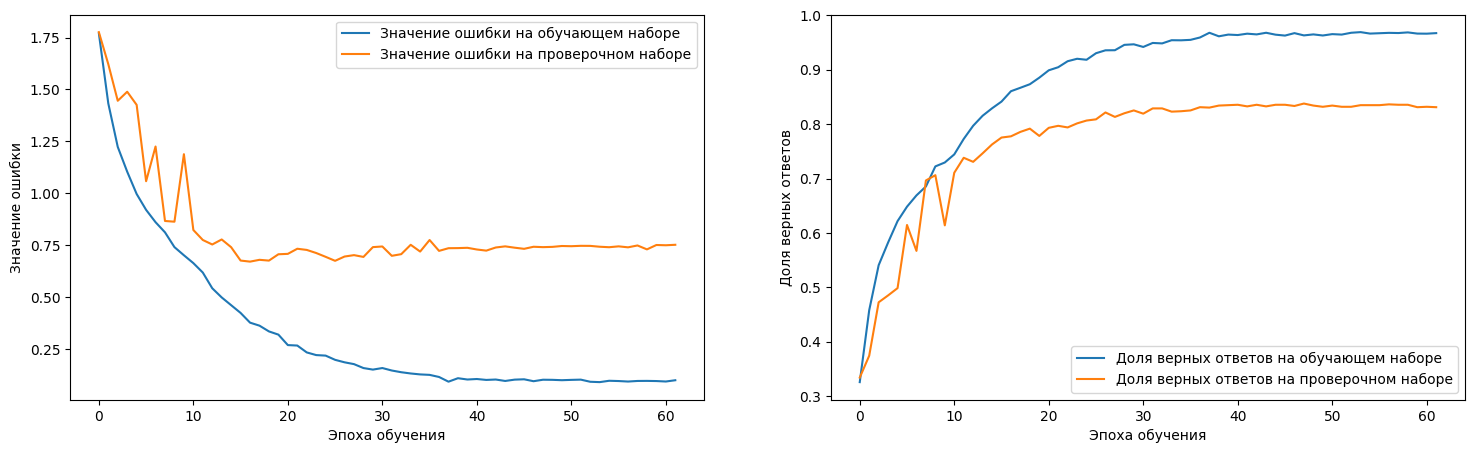

: 

In [ ]:
plot_history(hist)

In [ ]:
model7_864_3d.save('model7.h5') # сохраним модель

# Model inference

## загрузка модели

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_test = load_model('model7.h5') # загрузим сохраненную модель

In [ ]:
model_test.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 20, 80, 80, 1)     4         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 20, 80, 80, 8)     4104      
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 20, 80, 80, 8)     32776     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 10, 40, 40, 8)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 10, 40, 40, 8)     32        
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 40, 40, 16)    27664     
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 10, 40, 40, 16)   

## блок обрабоки входящего видео

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def load_faces (path, max_frames=-1, resize=(80, 80)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_g = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Захватываем фрейм в ч/б формате
            faces = detector(frame_g) # Ищем лицо
            if len(faces) >0:
              frame = frame_g[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()] # Вырезаем лицо
              try:
                frame = cv2.resize(frame, resize) # Приводим к заданному размеру
                frames.append(frame)
              except:
                continue
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) # Возвращаем массив лиц из видео

def predict_action(path,model):
    classes = {0: 'гнев', 1 : 'отвращение', 2 : 'страх', 3 : 'счастье', 4 : 'нейтральное состояние', 5 : 'печаль', 6 : 'удивление'}
    frames = load_faces(path)
    if len(frames)>20:
        countfr = len(frames)-20
        temp_pred = []
        for i in range(countfr):
            temp_pred.append(frames[i:i+20])
        pred =np.array(temp_pred)/255
        pred = pred.reshape(countfr,20,80,80,1)

        b = randint(0,len(frames)-20)
        frames = frames[b:b+20]
        #frames = frames[0:20]
        frames = frames.reshape(20,80,80,1)
    else:
         diff = 20 - len(frames)
         padding = np.zeros((diff, 80, 80, 1))
         frames = frames.reshape(len(frames),80,80,1)
         frames = np.concatenate((frames, padding))
         pred = frames[None, ...]/255


    probabilities = model.predict(pred)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {classes[i]}: {probabilities[i] * 100:5.2f}%")

    print(f"Человек на видео испытывает {classes[np.argmax(probabilities)]}")
    return frames

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

## предикт тестового видео

In [ ]:
test_path = 'D:/vkr_video/test_video/emotions_60.mp4'

Test video path: D:/vkr_video/test_video/emotions_60.mp4
  печаль: 54.66%
  страх: 37.80%
  удивление:  4.36%
  нейтральное состояние:  2.76%
  отвращение:  0.40%
  гнев:  0.02%
  счастье:  0.00%
Человек на видео испытывает печаль



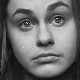

In [ ]:
print(f"Test video path: {test_path}")
test_frames = predict_action(test_path,model_test)
to_gif(test_frames)